### Adapting GVP for arbitrary (proteins) point clouds

In [2]:
import os
import sys
import time
sys.path.append("../geometric_vector_perceptron")

import torch
import numpy as np
from einops import rearrange, repeat
import matplotlib.pyplot as plt
# custom utils
from data_handler import *
from data_utils import *
# custom model
from geometric_vector_perceptron import *
# process and dataset
import gc
import joblib
from tqdm import tqdm
from functools import partial

In [3]:
# data
import sidechainnet
from sidechainnet.utils.sequence import ProteinVocabulary as VOCAB
VOCAB = VOCAB()

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # "cpu")

### Dataloader for training

In [5]:
MAX_LEN = 110
MAX_PROTS = 36

In [7]:
# check dataloader works
dataloaders_ = sidechainnet.load(casp_version="debug", with_pytorch="dataloaders")
dataloaders_.keys() # ['train', 'train_eval', 'valid-10', ..., 'valid-90', 'test']
train_examples_storer = [get_prot(dataloader_=dataloaders_, vocab_=VOCAB, max_len=MAX_LEN, verbose=0)\
                         for i in tqdm(range(100))]

# dataloaders won't work on my windows (idk why, so load examples from disk and train)
# train_examples_storer = joblib.load("sidechainnet_data/800_under_200.joblib")

  0%|          | 0/100 [00:00<?, ?it/s]

SidechainNet was loaded from ./sidechainnet_data/sidechainnet_debug.pkl.


100%|██████████| 100/100 [00:10<00:00,  9.65it/s]


## Data encoding dims and instantiate model

In [6]:
NEEDED_INFO = {"cutoffs": [-1e-7],
               "bond_scales": [1],
               "aa_pos_scales": [1,2,4,8,16,32,64,128],
               "atom_pos_scales": [1,2,4,8,16,32],
               "dist2ca_norm_scales": [1,2,4],
               "bb_norms_atoms": [0.5] # will encode 3 vectors with this
              }
# get model sizes from encoded protein
seq, true_coords, angles, padding_seq, mask = train_examples_storer[-1] 
NEEDED_INFO["seq"] = seq[:-padding_seq]
NEEDED_INFO["covalent_bond"] = prot_covalent_bond(seq)

# encode as needed
encoded = encode_whole_protein(seq, true_coords, angles, padding_seq, needed_info=NEEDED_INFO, free_mem=True)
x, edge_index, edge_attrs, embedd_info = encoded
embedd_info

{'point_n_vectors': 7,
 'point_n_scalars': 48,
 'bond_n_vectors': 1,
 'bond_n_scalars': 4,
 'bond_embedding_nums': [2]}

In [7]:
# define model
model = GVP_Network(n_layers=4, feats_x_in=48, vectors_x_in=7,
                                feats_x_out=48, vectors_x_out=7,
                                feats_edge_in=4, vectors_edge_in=1,
                                feats_edge_out=4, vectors_edge_out=1,
                                embedding_nums=[36, 20], embedding_dims=[16,16], # from _nums to _dims
                                edge_embedding_nums=[2], edge_embedding_dims=[2], residual=True)

In [8]:
# calc training sample:
for th in [75, 90, 100, 120, 140]:
    print("under", th, "aas, we have:", sum([len(x[0])<th for x in train_examples_storer]), "proteins")

under 75 aas, we have: 0 proteins
under 90 aas, we have: 17 proteins
under 100 aas, we have: 36 proteins
under 120 aas, we have: 36 proteins
under 140 aas, we have: 36 proteins


### Train

In [9]:
model = model.to(device) # .double()

In [10]:
noise = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [26]:
model.train()

# info records
baseline_losses = []
epoch_losses    = []
tac    = time.time()
# training run params
max_seq_len = MAX_LEN
iteration   = 0
n_per_iter  = MAX_PROTS
for ep in range( int( 2*n_per_iter ) ): # 
    # delete useless data from prev iter - but not in last one
    if ep > 0:
        del trim_coords, true_coords 
        del angles, pre_target_x, edge_index, edge_attrs
        del scores, target_coords, pred_coords, base_coords
        del encoded, pre_target, target_aligned, pred_aligned
        gc.collect()
        
    # get input data and target - copy to gpu
    seq, true_coords, angles, padding_seq, mask = get_prot(dataloader_=dataloaders_,
                                                           vocab_=VOCAB, 
                                                           max_len=MAX_LEN, 
                                                           verbose=0)
    # define edge_attr recalculator + add seq for feature calc
    NEEDED_INFO["seq"] = seq[:-padding_seq]
    NEEDED_INFO["covalent_bond"] = prot_covalent_bond(seq)
    recalc_edge = partial(encode_whole_bonds, x_format = "encode",
                                              embedd_info = embedd_info,
                                              needed_info = NEEDED_INFO,
                                              free_mem = True)
    # avoid seqs above limit
    if len(seq) > max_seq_len: 
        continue
    true_coords = true_coords.to(device) # .double()
    angles = angles.to(device)           # .double()
    
    # mask sidechains to position of cbeta   
    trim_coords = rearrange(true_coords.clone(), '(l c) d -> l c d', c=14)
    trim_coords[:, 4:] = repeat(trim_coords[:, 4], 'l d -> l sc d', sc=10)
    trim_coords = rearrange(trim_coords, 'l c d -> (l c) d', c=14)
    
    # target is the position of every atom (unit_vec, norm_scale)
    pre_target = encode_whole_protein(seq,
                                      true_coords,
                                      angles,
                                      padding_seq,
                                      needed_info=NEEDED_INFO, free_mem=True)
    pre_target_x, _, _, embedd_info = pre_target
    # encode as needed (noise mask)
    encoded = encode_whole_protein( seq,
                                    trim_coords + noise*torch.randn_like(trim_coords),
                                    angles,
                                    padding_seq,
                                    needed_info=NEEDED_INFO, free_mem=True)
    x, edge_index, edge_attrs, embedd_info = encoded
    batch = torch.tensor([0 for i in range(x.shape[0])], device=device).long()
    
    # predict
    scores = model.forward(x, edge_index, batch=batch, edge_attr=edge_attrs,
                           recalc_edge=recalc_edge, verbose = False)
    # format pred, baseline and target
    target = from_encode_to_pred(pre_target_x, embedd_info=embedd_info, needed_info=NEEDED_INFO)
    pred   = from_encode_to_pred(scores, embedd_info=embedd_info, needed_info=NEEDED_INFO)
    base   = from_encode_to_pred(x, embedd_info=embedd_info, needed_info=NEEDED_INFO)
    
    # MEASURE ERROR
    
    # option 1: loss is MSE on output tokens
    # loss_ = (target-pred)**2
    # loss  = loss_.mean()
    
    # option 2: loss is RMSD on reconstructed coords - unit vector + norm
    target_coords = target[:, 3:4] * target[:, :3] #  * (1 / torch.norm(target[:, :3], dim=-1, keepdim=True) )
    pred_coords   = pred[:, 3:4] * pred[:, :3] # * ( 1 / torch.norm(pred[:, :3], dim=-1, keepdim=True) )
    base_coords   = base[:, 3:4] * base[:, :3] # * ( 1 / torch.norm(base[:, :3], dim=-1, keepdim=True) )
    ## align - sometimes svc fails - idk why
    try:
        pred_aligned, target_aligned = kabsch_torch(pred_coords.t(), target_coords.t()) # (3, N)
        loss = ((pred_aligned - target_aligned)**2).mean()**0.5 
    except:
        pred_aligned, target_aligned = None, None
        print("svd failed convergence, ep:", ep)
        break
        loss = ((pred_coords - target_coords)**2).mean()**0.5
    # measure error
    loss_base = ((base_coords - target_coords)**2).mean()**0.5 
    # not aligned: # loss = ((pred_coords - target_coords)**2).mean()**0.5 

    
    # back pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # records / prints
    iteration += 1
    epoch_losses.append( loss.item() )
    baseline_losses.append( loss_base.item() )
    if iteration % 10 == 1:
        tic = time.time()
        print("BATCH: {0} / {1}, loss: {2}, baseline_loss: {3}, time: {4}".format(iteration, n_per_iter,
                                                                                  epoch_losses[-1],
                                                                                  baseline_losses[-1],
                                                                                  tic-tac))
        tac = time.time()
        if iteration % n_per_iter == 1:
            print("---------------------------------")

BATCH: 1 / 36, loss: 4.0196123123168945, baseline_loss: 22.343225479125977, time: 0.37283802032470703
---------------------------------
BATCH: 11 / 36, loss: 5.497391223907471, baseline_loss: 15.93697738647461, time: 4.223315238952637
BATCH: 21 / 36, loss: 4.987957000732422, baseline_loss: 1.4535179138183594, time: 4.070893287658691
BATCH: 31 / 36, loss: 3.604379892349243, baseline_loss: 12.076339721679688, time: 4.37068510055542
BATCH: 41 / 36, loss: 4.109440326690674, baseline_loss: 5.734999179840088, time: 4.128391981124878
BATCH: 51 / 36, loss: 3.7348809242248535, baseline_loss: 1.0075886249542236, time: 4.187558889389038
BATCH: 61 / 36, loss: 5.611117362976074, baseline_loss: 11.786128044128418, time: 4.165405988693237
BATCH: 71 / 36, loss: 4.964354515075684, baseline_loss: 8.175503730773926, time: 4.0920939445495605


In [27]:
np.mean(baseline_losses) # recorded inside training loop

10.376206285423702

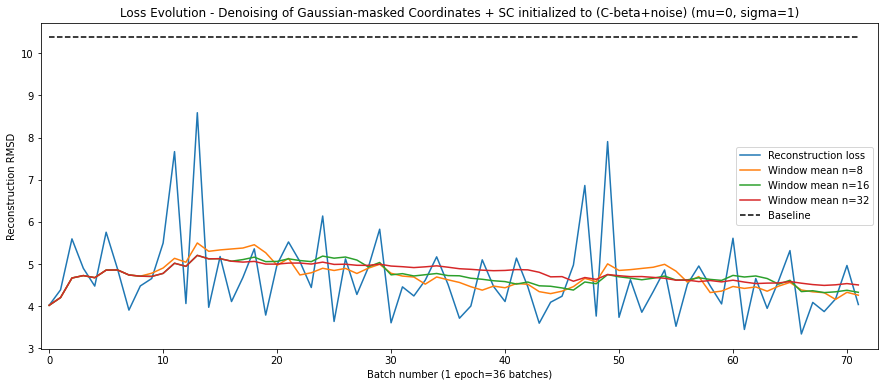

In [28]:
plt.figure(figsize=(15,6))
plt.title("Loss Evolution - Denoising of Gaussian-masked Coordinates + SC initialized to (C-beta+noise) (mu=0, sigma=1)")
plt.plot(epoch_losses, label="Reconstruction loss")

for window in [8,16,32]:
    plt.plot([np.mean(epoch_losses[:window][0:i+1]) for i in range(window)] + \
             [np.mean(epoch_losses[i:i+window+1]) for i in range(len(epoch_losses)-window)], 
             label="Window mean n={0}".format(window))

plt.plot(np.ones(len(epoch_losses))*np.mean(baseline_losses), "k--", label="Baseline")
    
# plt.yscale("log")
plt.xlim(-0.01*len(epoch_losses),1.01*len(epoch_losses))
plt.ylabel("Reconstruction RMSD")
plt.xlabel("Batch number (1 epoch={0} batches)".format( sum([len(x[0])<max_seq_len for x in train_examples_storer]) ))
plt.legend()
plt.show()

### Measure rmsd on (the last trained) reconstructed protein

* Not passing through the model

In [29]:
unfiltered = from_encode_to_pred(x, embedd_info=embedd_info, needed_info=NEEDED_INFO)
# reconstruct coordinates
target_coords = target[:, :3] * target[:, 3:4]
unfiltered_coords = unfiltered[:, :3] * unfiltered[:, 3:4]
print("MSE between reconstructed coords: ", ((unfiltered_coords - target_coords)**2).mean()**0.5 ) 

MSE between reconstructed coords:  tensor(12.9396)


* passing through the model

In [30]:
# unfiltered = from_encode_to_pred(scores, embedd_info, needed_info=NEEDED_INFO)
# reconstruct coordinates
target_coords = target[:, :3] * target[:, 3:4]
sample_pred_coords = pred[:, :3] * pred[:, 3:4]
# rotate / align
pred_aligned, target_aligned = kabsch_torch(sample_pred_coords.t(), target_coords.t()) # (3, N)
print("MSE between reconstructed coords: ", ((pred_aligned - target_aligned)**2).mean()**0.5 ) 

MSE between reconstructed coords:  tensor(4.0383, grad_fn=<PowBackward0>)


In [31]:
# 2 norms # 2 unit vectors
(unfiltered[:, 3:4] - target[:, 3:4]).view(-1).mean(), \
(pred[:, 3:4] - target[:, 3:4]).view(-1).mean(), \
torch.norm(unfiltered[:, :3] - target[:, :3], dim=-1).view(-1).mean(), \
torch.norm(pred[:, :3] - target[:, :3], dim=-1).view(-1).mean()

(tensor(-17.6626),
 tensor(-21.4663, grad_fn=<MeanBackward0>),
 tensor(0.6322),
 tensor(0.9750, grad_fn=<MeanBackward0>))

### Make a plot of a reconstructed protein

In [32]:
scaffs  = build_scaffolds_from_scn_angles(seq[:-padding_seq], angles[:-padding_seq].cpu())
wrapper = torch.zeros(*scaffs["cloud_mask"].shape, 3).cpu()
# rebuild target
target_rebuilt = wrapper.clone()
target_rebuilt[scaffs["cloud_mask"].cpu()] = true_coords[:-14*padding_seq][scaffs["cloud_mask"].cpu().view(-1)]
# rebuild encoded-decoded
pre_target_rebuilt = wrapper.clone()
pre_target_rebuilt[scaffs["cloud_mask"].cpu()] = target_coords.cpu()
# build input coords (w/out sidechain)
input_rebuilt = wrapper.clone()
input_rebuilt[scaffs["cloud_mask"].cpu()] = trim_coords.cpu()[:-14*padding_seq][scaffs["cloud_mask"].cpu().view(-1)]
# build predicted
pred_rebuilt = wrapper.clone()
pred_rebuilt[scaffs["cloud_mask"].cpu()] = pred_coords.cpu()

In [33]:
sb = sidechainnet.StructureBuilder( torch.tensor([AAS.index(x) for x in seq[:-padding_seq]]),
                                    crd=rearrange(target_rebuilt, 'l c d -> (l c) d') ) # pred_rebuilt
sb.to_pdb("preds/sample_reconstruction_target.pdb")
sb.to_3Dmol()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [34]:
sb = sidechainnet.StructureBuilder( torch.tensor([AAS.index(x) for x in seq[:-padding_seq]]),
                                    crd=rearrange(input_rebuilt, 'l c d -> (l c) d') ) # pred_rebuilt
sb.to_pdb("preds/sample_reconstruction_input.pdb")
sb.to_3Dmol()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [35]:
sb = sidechainnet.StructureBuilder( torch.tensor([AAS.index(x) for x in seq[:-padding_seq]]),
                                    crd=rearrange(pred_rebuilt, 'l c d -> (l c) d') ) # pred_rebuilt
sb.to_pdb("preds/sample_reconstruction_pred.pdb")
sb.to_3Dmol()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol